In [89]:
import pandas as pd
import tt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

In [114]:
def savearray(q, n, arr, filename):
    f2 = open(filename, 'w')
    for idx in product(range(n), repeat=q):
            f2.write(str(np.array(idx)) + ' ')
            for elem in arr[idx]:
                f2.write(str(elem) + ' ')
            f2.write('\n')
    f2.close() 
    
def saveall(JP_pred, JE_pred, UP_pred, UE_pred):
    JP_pred = JP_pred.full()
    JE_pred = JE_pred.full()
    UP_pred = UP_pred.full().astype(int)
    UE_pred = UE_pred.full().astype(int)
    savearray(3, 11, JP_pred, 'with_tt_jp.txt')
    savearray(3, 11, JE_pred, 'with_tt_je.txt')
    savearray(4, 11, UP_pred, 'with_tt_up.txt')
    savearray(4, 11, UE_pred, 'with_tt_ue.txt')    

In [115]:
Delta_max = 1e-2 
delta_max = 1e-2 
gamma = 0.7
K_max = 50
k_max = 100

from_ = 0
to_ = 10
n = 11

In [116]:
def get_data(from_, to_, n):
    x_grid = np.linspace(from_, to_, n)
    y_grid = np.linspace(from_, to_, n)
    
    return x_grid, y_grid

In [117]:
JP_pred = np.zeros((n, n, n, n))
JE_pred = np.zeros((n, n, n, n))
JP_next = np.zeros((n, n, n, n))
JE_next = np.zeros((n, n, n, n))
JP = np.zeros((n, n, n, n))
JE = np.zeros((n, n, n, n))
G = np.zeros((n, n, n, n))
sizes = np.array([n, n, n, n]).astype(int)
UP_pred = np.ones((n, n, n, n, 2))*1e-10
UE_pred = np.ones((n, n, n, n, 2))*1e-10
UP_next = np.ones((n, n, n, n, 2))*1e-10
UE_next = np.ones((n, n, n, n, 2))*1e-10
x_grid, y_grid = get_data(from_, to_, n)
up_x = np.arange(-2, 3).astype(int)
up_y = np.arange(-2, 3).astype(int)
ue_x = np.arange(-1, 2).astype(int)
ue_y = np.arange(-1, 2).astype(int)

In [118]:
arr1 = np.arange(n)
arr2 = np.arange(n)
arr3 = np.arange(n)
arr4 = np.arange(n)
arr1_tt = tt.tensor(arr1)
arr2_tt = tt.tensor(arr2)
arr3_tt = tt.tensor(arr3)
arr4_tt = tt.tensor(arr4)
e1 = tt.tensor(np.ones(n))
e2 = tt.tensor(np.ones(n))
e3 = tt.tensor(np.ones(n))
e4 = tt.tensor(np.ones(n))
I1 = tt.kron(tt.kron(tt.kron(arr1_tt, e2), e3), e4)
I2 = tt.kron(tt.kron(tt.kron(e1, arr2_tt), e3), e4)
I3 = tt.kron(tt.kron(tt.kron(e1, e2), arr3_tt), e4)
I4 = tt.kron(tt.kron(tt.kron(e1, e2), e3), arr4_tt)

In [119]:
for idx, val in zip(product(range(n), repeat=4), product(x_grid, y_grid, x_grid, y_grid)):
    JP_pred[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2 
    JE_pred[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2
    G[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2 + 10

In [120]:
def get_neighbors(idx, sizes, up, ue, mode):
    up = up.astype(int)
    ue = ue.astype(int)
    neighbors = list()
    pos_list = list()
    if mode == 'p':
        z = list(idx)
        z[2] += ue[0]
        z[3] += ue[1]
        for positions in product(up_x, up_y):
            if ((idx[0] + positions[0] >= 0) and (idx[0] + positions[0] < sizes[0]) and 
                (idx[1] + positions[1] >= 0) and (idx[1] + positions[1] < sizes[1])):
                z[0] = idx[0] + positions[0]
                z[1] = idx[1] + positions[1]
                neighbors.append(tuple(z))
                pos_list.append(np.array(positions))
    if mode == 'e':
        z = list(idx)
        z[0] += up[0]
        z[1] += up[1]
        for positions in product(ue_x, ue_y):
            if ((idx[2] + positions[0] >= 0) and (idx[2] + positions[0] < sizes[2]) and 
                (idx[3] + positions[1] >= 0) and (idx[3] + positions[1] < sizes[3])):
                z[2] = idx[2] + positions[0]
                z[3] = idx[3] + positions[1]
                neighbors.append(tuple(z))
                pos_list.append(np.array(positions))
                
    return neighbors, pos_list

In [121]:
def solve(neighbors, pos_list, G, J_pred, mode, gamma=0.7):
    function_vals = np.zeros(len(neighbors))
    for i, neighbor in enumerate(neighbors):
        function_vals[i] = G[neighbor] + gamma * J_pred[neighbor]
    if mode == 'p':
        idx = np.argmin(function_vals)
        val = function_vals[idx]
        pos = pos_list[idx]
    elif mode == 'e':
        idx = np.argmax(function_vals)
        val = function_vals[idx]
        pos = pos_list[idx]
    else:
        print 'Mode is not correct!'
    
    return val, pos

In [122]:
def tt_cross_P(V):
    result = np.zeros((V.shape[0], 3))
    for i in xrange(V.shape[0]):
        idx = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]))
        idx1 = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]), 0)
        idx2 = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]), 1)
        neighbors, pos_list = get_neighbors(idx, sizes, up=np.zeros(2), 
                                            ue=np.array([UE_pred[idx1], UE_pred[idx2]]), mode='p')
        value, positions = solve(neighbors, pos_list, G, JP_pred, mode='p')
        result[i, 0] = value
        result[i, 1] = positions[0]
        result[i, 2] = positions[1]
        
    return result

def tt_cross_E(V):
    result = np.zeros((V.shape[0], 3))
    for i in xrange(V.shape[0]):
        idx = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]))
        idx1 = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]), 0)
        idx2 = (int(V[i, 0]), int(V[i, 1]), int(V[i, 2]), int(V[i, 3]), 1)
        neighbors, pos_list = get_neighbors(idx, sizes, 
                                            up=np.array([UP_pred[idx1], UP_pred[idx2]]), ue=np.zeros(2), mode='e')
        value, positions = solve(neighbors, pos_list, G, JE_pred, mode='e')
        result[i, 0] = value
        result[i, 1] = positions[0]
        result[i, 2] = positions[1]
        
    return result

In [123]:
f2_r = open('with_tt_report.txt', 'w')
JP = JP_pred.copy()
JE = JE_pred.copy()
JP = tt.tensor(JP)
JE = tt.tensor(JE)
JP_pred = tt.tensor(JP_pred)
UP_pred = tt.tensor(UP_pred)
JE_pred = tt.tensor(JE_pred)
UE_pred = tt.tensor(UE_pred)
Delta_p = Delta_max + 1
Delta_e = Delta_max + 1
K = 0
while ((Delta_p > Delta_max) and (Delta_e > Delta_max) and (K < K_max)):
    delta = delta_max + 1
    k = 0
    while ((delta > delta_max) and (k < k_max)):
        new_tensor1 = tt.multifuncrs2([I1, I2, I3, I4], tt_cross_P, eps=1e-3, d2=3, verb=0)
        new_array1 = new_tensor1.full().reshape((-1), order='f').reshape((
                n, n, n, n, 3), order='f').reshape((n, n, n, n, 3), order='c')
        JP_next = tt.tensor(new_array1[:, :, :, :, 0])
        UP_next = tt.tensor(new_array1[:, :, :, :, 1:])
        k += 1
        delta = (JP_next - JP_pred).norm() ** 2
        JP_pred = JP_next.copy()
        UP_pred = UP_next.copy()
        f2_r.write('P ' + str(k) + ' ' + str(delta) + '\n')
    delta = delta_max + 1
    k = 0
    while ((delta > delta_max) and (k < k_max)):
        new_tensor2 = tt.multifuncrs2([I1, I2, I3, I4], tt_cross_E, eps=1e-3, d2=3, verb=0)
        new_array2 = new_tensor2.full().reshape((-1), order='f').reshape((
                n, n, n, n, 3), order='f').reshape((n, n, n, n, 3), order='c')
        JE_next = tt.tensor(new_array2[:, :, :, :, 0])
        UE_next = tt.tensor(new_array2[:, :, :, :, 1:])
        k += 1
        delta = (JE_next - JE_pred).norm() ** 2
        JE_pred = JE_next.copy()
        UE_pred = UE_next.copy()
        f2_r.write('E ' + str(k) + ' ' + str(delta) + '\n')
    Delta_p = (JP - JP_pred).norm() ** 2
    Delta_e = (JE - JE_pred).norm() ** 2
    JE = JE_pred.copy()
    JP = JP_pred.copy()
    UE = UE_pred.copy()
    UP = UP_pred.copy()
    K += 1
    f2_r.write('K ' + str(K) + ' ' + str(Delta_p) + ' ' + str(Delta_e) + '\n')  
f2_r.close()

KeyboardInterrupt: 

In [125]:
saveall(JP_pred, JE_pred, UP_pred, UE_pred)

In [89]:
UE_pred[0, 0, 0, 0, 0]

1.0000000000000004

/home/ilya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ilya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


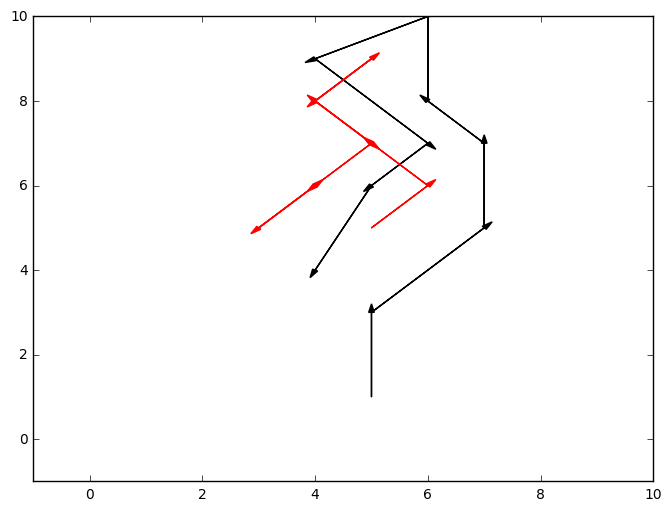

In [91]:
z_init = (5, 1, 5, 5)
p_pos_array = []
e_pos_array = []
p_pos = np.array(z_init[:2])
e_pos = np.array(z_init[2:])
for i in range(10):
    p_pos_array.append(p_pos)
    e_pos_array.append(e_pos)
    p_pos = np.array(p_pos) + UP.full()[p_pos[0], p_pos[1], e_pos[0], e_pos[1]]
    e_pos = np.array(e_pos) + UE.full()[p_pos[0], p_pos[1], e_pos[0], e_pos[1]]
    
plt.figure(figsize=(8, 6))
#for i in range(10):
#    plt.plot(p_pos_array[i][0], p_pos_array[i][1], 'ro', markersize=10)
    
for i in range(9):
    x_start = p_pos_array[i][0]
    y_start = p_pos_array[i][1]
    dx = p_pos_array[i + 1][0] - p_pos_array[i][0]
    dy = p_pos_array[i + 1][1] - p_pos_array[i][1]
    plt.arrow(x_start, y_start, dx, dy, head_width=0.1, head_length=0.2, fc='k', ec='k')
    
#for i in range(10):
#    plt.plot(e_pos_array[i][0], e_pos_array[i][1], 'bo')

for i in range(9):
    x_start = e_pos_array[i][0]
    y_start = e_pos_array[i][1]
    dx = e_pos_array[i + 1][0] - e_pos_array[i][0]
    dy = e_pos_array[i + 1][1] - e_pos_array[i][1]
    plt.arrow(x_start, y_start, dx, dy, head_width=0.1, head_length=0.2, fc='r', ec='r')
    
plt.xlim((-1, 10))
plt.ylim((-1, 10))
plt.show()

In [328]:
p_pos_array

[array([5, 1]),
 array([4, 3]),
 array([5, 5]),
 array([6, 6]),
 array([7, 7]),
 array([8, 8]),
 array([9, 9]),
 array([10, 10]),
 array([11, 11]),
 array([12, 12])]

In [329]:
e_pos_array

[array([5, 5]),
 array([6, 6]),
 array([7, 7]),
 array([8, 8]),
 array([9, 9]),
 array([10, 10]),
 array([11, 11]),
 array([12, 12]),
 array([13, 13]),
 array([14, 14])]